* [Introduction](#section0)
* [1. Data Preparation and Preprocessing](#section1)
* [2. Features Engineering](#section2)
* [3. Preparing Data for Model Fitting](#section3)
* [4. Models](#section4)
    - [4.1 Model Fitting](#section4.1)
    - [4.2 Model Evaluation](#section4.2)
* [5. Predictions](#section5)
* [6. Division of Labor](#section6)

# 0. Introduction <a class="anchor"  id="section0"></a>

In this competition we will predict customer sentiments regarding [Baby products purchased on Amazon.com](http://jmcauley.ucsd.edu/data/amazon/), on the basis of their written reviews. 

Answer the 3 most important questions for any ML project:

1. Where do the data come from? (To which population will results generalize?)
2. What are candidate machine learning methods? (models? features?)
3. What is the Bayes' error bound?


<div style=color:darkblue;background-color:#fafaff;min-height:8em; >

1. The data originates from Amazon users who provided reviews for baby products. This means it should generalize well to future such reviews as the ecological validity of the gathered data is high. However, it might not generalize to reviews of other products as the people who review baby products might have systematically different characteristics than people who review other types of products (e.g. predominantly women in their early 30s). The data was provided by Professors Emily Fox, Ph.D. and Carlos Guestrin, Ph.D. and can be found on the 
<a href="https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews">UCSD server</a>.
    
2. Candidate machine learning methods include lasso regression, ridge regression, principal components regression, partial least squares regression and smoothing splines.
    
3. There are 36,193 non-satisfied reviews in the dataset and 117,338 satisfied reviews in the dataset. Therefore, simply always predicting a review will be satisfied would give us an 76.43% accuracy on the test data. We would definitely expect the Bayes' error bound to be higher than this. Additionally, identifying reviews as satisfied or unsatisifed is a relatively easy task for humans, however, machine learning models might struggle with some aspects of this task such as sarcasm or context that come easier to humans. Overall, the exact value of the Bayes' error bound is difficult to determine.
</div>

# 1. Data Preparation and Preprocessing <a class="anchor"  id="section1"></a>

In this section, we load necessary packages, read the Amazon Baby Product dataset, and briefly inspect its initial contents.

In our dataset, we have product names, reviews, and ratings. Since product quality affects ratings, we want to include the product identity as a predictive feature. To do this, we combine the product `name` with the `review` text by merging them into a single string using the `unite()` function. This approach also helps when we encounter empty reviews, as we can still use the product names to predict their rating.

In [1]:
# import required packages

suppressPackageStartupMessages({
  library(tidyverse)
  library(tidytext)
  library(glmnet)
  library(dplyr)
  library(doMC)
})

# find the right file path
csv_filepath <- dir("..", pattern="amazon_baby.csv", recursive=TRUE, full.names = TRUE)

# read in the csv file
amazon <- read_csv(csv_filepath, show_col_types = FALSE) %>%
    rownames_to_column('id') 

# Paste name and review into a single string separated by a "–".
amazon <- amazon %>% 
    unite(review, name, review, sep = " — ", remove = FALSE) %>%
    mutate(rating = ifelse(rating > 3, "Satisfied", "Dissatisfied"))

# inspect df
head(amazon, 3)

id,review,name,rating
<chr>,<chr>,<chr>,<chr>
1,"Planetwise Flannel Wipes — These flannel wipes are OK, but in my opinion not worth keeping. I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality. I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues for a while that stripping no longer handles.",Planetwise Flannel Wipes,Dissatisfied
2,Planetwise Wipe Pouch — it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.,Planetwise Wipe Pouch,Satisfied
3,Annas Dream Full Quilt with 2 Shams — Very soft and comfortable and warmer than it looks...fit the full size bed perfectly...would recommend to anyone looking for this type of quilt,Annas Dream Full Quilt with 2 Shams,NA


In the dataset, the training and testing data are combined. The testing data consists of reviews where the rating is `NA`, and we will provide predictions for these missing cases. To simplify the process of choosing the relevant rows, we introduce a logical index variable `trainidx`. It checks each row in the `amazon` dataframe's `rating` column to see if the value is not missing (i.e., not `NA`). It assigns `TRUE` to `trainidx` for rows where the rating is not missing and `FALSE` for rows where it is missing.

* This eliminates the need to divide the dataset into separate sets, which, in turn, streamlines the feature extraction process.

* As can be seen on the output, we have 153.531 training samples and 30.000 test samples.

In [2]:
trainidx <- !is.na(amazon$rating)
table(trainidx)

trainidx
 FALSE   TRUE 
 30000 153531 

## 1.1 Data Description & Goal <a class="anchor"  id="section1.1"></a>

The data consits of **textual reviews of baby products** bought through the online retail website Amazon. After purchasing a baby product through the retailer customers were invited to fill in the review on the website. 153,531 of these textual reviews also have a **rating on a 5-star scale** associated with them. 
Based on the characteristics of these reviews it is our goal to train an algorithm that will accurately predict whether the 30,000 textual reviews without associated star ratings are from **satisfied or unsatisfied customers**. A satisfied customer here is operationalized as one that leaves a **4-star or 5-star review** while an unsatisfied customer is operationalized as one that leaves a 1-star, 2-star or 3-star review.
This kind of algorithm can have widespread application especially in commercial settings. It can save time and resources while **identifying areas for product improvement** or help **tailor product recommendations** based on customer's sentiments in previous reviews.

## 1.2 Tokenization <a class="anchor"  id="section1.2"></a>

In this section, we delve into the process of text tokenization to facilitate feature engineering and enhance subsequent analyses. This process involves breaking down the textual data into smaller units, and we perform single-word tokenization on `reviews`.

For this analysis, we decided to not to exclude ***stopwords*** from our textual data. In our specific context, stopwords such as "no" and "not" may carry valuable information regarding the review. By retaining them, we aim to gain a broader understanding of the textual data and keep the natural structure of the language.

### 1.2.1 Single-Word Tokenization <a class="anchor"  id="section1.2.1"></a>
We tokenize the reviews at the single word level and count the frequency of each word within the reviews while keeping the essential product information. To link each review with its respective entry, we include a column labeled id, which essentially represents the row number of the corresponding review.



In [3]:
word_tokens <- amazon %>% 

   # tokenize reviews at word level
   unnest_tokens(token, review, token = "words") %>%

   # count tokens within reviews as 'n'
   count(id, name, rating, token)

head(word_tokens, 3)

id,name,rating,token,n
<chr>,<chr>,<chr>,<chr>,<int>
1,Planetwise Flannel Wipes,Dissatisfied,12,1
1,Planetwise Flannel Wipes,Dissatisfied,6,1
1,Planetwise Flannel Wipes,Dissatisfied,8,1



# 2. Features Engineering <a class="anchor"  id="section2"></a>

Features computed for tokens in text are based on the Bag of Words (BoW) model: Each document is considered a bag of words, in wich order plays no particular. A better name would be Bag of Tokens, because tokens can also be bi-grams etc, but we're stuck with BoW. Common features are


- **document occurence**: 
    > 0-1 encoding of the presence or absence of a token in a document (here: review)
    
- **token counts**: 
    > simple counts $n_{t,d}$ of each token $t$ within documents $d$ (resulting in a document by term matrix, or DTM)

- **term frequency ($TF_{d,t}$)**: 
    > the relative frequency of a term within a document $\displaystyle {n_{d,t} \over  \sum_t n_{d,t}}$

- **inverse document frequency ($IDF_t$)**: 
    > inverse the relative frequency with which a term occurs among the $N$ documents, expressed on a log scale (a measure of 'surprise') as  $-\log\left({DF_t \over N}\right)$ Here $DF_t$ is the number of documents that contain the token $t$.

- **the $TFIDF_{d,t}$**: 
    > the product of TF and IDF



The motivation for $TF_{d,t}$ is simply that the more often a token $t$ occurs in a document, the more likely it is that the topic of the document is closely related to that token. A problem of $TF_{d,t}$ is that it does not take into account that certain words simply occur more frequently because of their role in language (such as 'a', 'but', etc.). 

The motivation for the $IDF_t$ is that the more wide spread the use of a token $t$ is among all documents, the less likely it conveys information about the topic of any particular document. Hence, the more surprising a word is, the more likely it conveys information about the topic of the document in which it is found. 

The $TFIDF_{d,t}$ banks on both of these ideas and quantifies the important of a term for a given document. 

While $TFIDF_{d,t}$ is extensively applied and very successful in document retrieval systems (i.e., search engines), the $IDF_t$ part has much less use over $TF_{d,t}$ in *predictive* models because the $IDF_t$ part simply scales the $TF_{d,t}$ features accross documents. This scaling may have an effect on scale sensitive algorithms like PCA and algorithms that rely on Euclidean distances such as kNN. 



## 2.1 TF-IDF <a class="anchor"  id="section2.1"></a>

### 2.1.1 TF-IDF with Single-Words as Tokens <a class="anchor"  id="section2.1.1"></a>

First, we compute and bind the $TF$ and $IDF$ for single-word tokens using `bind_tf_idf` function.

**Near-zero variance features:** Our approach to handle the features with near-zero variances is to remove tokens occurring in less than 0.01% of the documents to eliminate uncommon and possibly erroneous terms. We filter features by their inverse document frequency ($IDF$) where $IDF_t$ values below $-\log(0.01/100)$ indicate low 'surprise' or common terms.



In [4]:
# compute TF-IDF for word tokens

tf_idf_words <- word_tokens %>%
    bind_tf_idf(token, id, n) %>%
    replace_na(list(tf = 0, idf = Inf, tf_idf = 0)) %>% # replace NAs with 0
    filter(idf <= -log(0.01 / 100)) %>% # filter out near-zero variances
    select(id, token, tf_idf) %>% # removing n, tf and idf columns
    rename(value = tf_idf)

# checking
head(tf_idf_words)

id,token,value
<chr>,<chr>,<dbl>
1,12,0.045978984
1,6,0.030938856
1,8,0.040013073
1,a,0.008632354
1,about,0.023040804
1,also,0.022591531


### 2.1.2 TF-IDF with Bigrams as Tokens <a class="anchor"  id="section2.1.2"></a>

Next, we tokenize the reviews at the bigram level where we form pairs of adjecent words. This approach could offer a more nuanced analysis, allowing us to account for context and uncover important patterns, especially those related to "negation words" (e.g., "not good"). Similar to single-word tokenization, we count the frequency of these bigrams and retain the corresponding product information. Finally, we compute and bind the $TF$ and $IDF$ for bigrams.

In [5]:
# Compute TF-IDF for bigrams
tf_idf_bigrams <- amazon %>% 
   unnest_tokens(token, review, token = "ngrams", n = 2) %>% # unnest to bigrams
   count(id, name, rating, token) %>%
   bind_tf_idf(token, id, n) %>% # get tf, idf and tf-idf
  replace_na(list(tf=0, idf=Inf, tf_idf=0)) %>% # replace NA's with 0
  filter(idf <= -log(0.01/100)) %>% # filter out near-zero variances
  rename(value = tf_idf) %>% 
  select(id, token, value) 


head(tf_idf_bigrams)
dim(tf_idf_bigrams)

id,token,value
<chr>,<chr>,<dbl>
1,6 pack,0.06150993
1,8 months,0.06099085
1,a nicer,0.09649717
1,a while,0.05405163
1,about 8,0.07926356
1,also ordered,0.09221965


[1] 12431575        3

## 2.2 Number of Words per Review <a class="anchor"  id="section2.2"></a>

Here we extract the number of words per review as a feature since analyzing word counts can be helpful in understanding how review length relates to the sentiment expression. Longer reviews with more words could suggest a lower rating for the product (Eslami et al., 2018).




In [6]:
# word count per review

word_count <- word_tokens %>%
    group_by(id) %>%
    summarise(value = sum(n)) %>%
    mutate(token = "total") %>%
    relocate(value, .after = last_col())

head(word_count)
dim(word_count)

id,token,value
<chr>,<chr>,<int>
1,total,84
10,total,92
100,total,37
1000,total,211
10000,total,50
100000,total,29


[1] 183531      3

## 2.3 Contextual Valence Shifters <a class="anchor"  id="section2.3"></a>

* **Intensifiers:** Words that emphasize a certain sentiment, or express an emotion more strongly (Bhasket et al., 2014). Intensifiers have a more positive valence associated with it (Carrillo-de-Albornoz et al., 2018). 
* **Negations**: Negations are the words that change the sentiment of a sentence and add a negative valence to it (Bhaskar et al., 2014). 

Libraries like `nltk` contain intensifiers and negations, but since we may not be able to use those, we come up with a list of intensifiers and negations on our own, and sum them up to calculate the intensification and negation score for each review. 

The lists were formed using the following sources:

**Intensifiers**: <br>
* *quite, pretty, rather, fairly* (Su et al., 2016)
* *absolutely, completely, totally* (Cao, 2020)
* *extremely, highly, really, so, too, utterly, very, at all* (Commonly used intensifiers according to the Cambridge Dictionary)
* *amazingly, exceptionally, incredibly, particularly, remarkably, unusually, much, far, a lot, quite a lot* (from the British Council website)
* *fully, perfectly, quite, greatly, highly, so, well* (examples in the previous literature section of Ohasahi, 2006)
* *especially, significantly, profoundly, considerably, enormously, excessively, tremendously, intensely, vastly, extraordinarily, literally, definitely, terribly* (ChatGPT, 2023)

**Negations:** <br>
* *not, no, none, neither, nor, never, nobody, nowhere, nothing, hardly, scarcely, barely, rarely, seldom, few, lack, without* (ChatGPT, 2023)



In [7]:
# Intensifiers
intensifiers <- tibble(words_int = c("quite", "pretty", "rather", "fairly","absolutely", "totally",
                               "completely", "extremely", "highly", "really", "so", "too", 
                               "utterly", "very", "at all", "amazingly", "exceptionally", 
                               "incredibly", "particularly", "remarkably", "unusually", "much", 
                               "far", "a lot", "quite a lot","fully", "perfectly", "quite", 
                               "greatly", "highly", "well", "especially", "significantly", 
                               "profoundly", "considerably", "enormously", "excessively", 
                               "tremendously", "intensely", "vastly", "extraordinarily",
                                "literally", "definitely", "terribly"))

# match word tokens with intensifiers
suppressWarnings({
  intensifier_words <- inner_join(word_tokens, intensifiers, by = c(token = "words_int"))
})

# calculate nr of intensifiers
intensifier_count <- intensifier_words %>%
                     select(id, token, n) %>%
                     group_by(id, token) %>%
                     summarise(value = sum(n)) %>% # count of intensifiers per id/review
                     mutate(token = "intensifier") %>%
                     relocate(value, .after = last_col())

head(intensifier_count, 3); dim(intensifier_count)

`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.


id,token,value
<chr>,<chr>,<int>
10,intensifier,2
1000,intensifier,1
10000,intensifier,2


[1] 301893      3

In [8]:
# Negations
negations <-  tibble(words_neg = c("not", "no", "none", "neither", "nor", "never",
                    "nobody", "nowhere", "nothing", "hardly", "scarcely",
                    "barely", "rarely", "seldom", "few", "lack", "without"))

# match word tokens with negations
suppressWarnings({
  negation_words <- inner_join(word_tokens, negations, by = c(token = "words_neg"))
})

# calculate nr of negations
negation_count <- negation_words %>%
                  select(id, token, n) %>%
                  group_by(id, token) %>%
                  summarise(value = sum(n)) %>% # sum of negations per review
                  mutate(token = "negation") %>%
                  relocate(value, .after = last_col())

head(negation_count, 3); dim(negation_count)

`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.


id,token,value
<chr>,<chr>,<int>
1,negation,1
1,negation,1
10,negation,2


[1] 129946      3

## 2.4 Punctuations <a class="anchor"  id="section2.4"></a>

Here, we extracted question marks and exclamation marks as features since they can provide valuable insights into the sentiment and tone of the text. Exclamation marks can signify strong emotions such as excitement and anger and can be used to emphasize a statement, while question marks can indicate uncertainty. 

In [9]:
# unnest tokens with punctuation
punct_tokens <- amazon %>%
    unnest_tokens(token, review, token = "words", strip_punct = FALSE) %>%
    select(id, token, value = rating)

# count question marks
q_mark_count <- punct_tokens %>%
                filter(token == "?") %>%
                group_by(id) %>%
                count() %>%
                mutate(token = "?") %>%
                rename(value = n) %>%
                relocate(value, .after = last_col())

head(q_mark_count)

# count exclamation marks
exc_mark_count <- punct_tokens %>%
                  filter(token == "!") %>%
                  group_by(id) %>%
                  count() %>%
                  mutate(token = "!") %>%
                  rename(value = n) %>%
                  relocate(value, .after = last_col())

head(exc_mark_count)

id,token,value
<chr>,<chr>,<int>
100076,?,1
100077,?,2
100082,?,1
100095,?,4
10010,?,1
100113,?,1


id,token,value
<chr>,<chr>,<int>
100,!,2
1000,!,1
10000,!,1
100001,!,2
10001,!,1
100020,!,1


## 2.5 Lexicons <a class="anchor"  id="section2.5"></a>

Sentiment-based/emotion-based lexicons such as the **NRC** and **AFINN** are very popularly used for sentiment analysis. They help extract and assign an emotional valence to tokens in a text with the goal to identify the sentiment/emotion associated with the text as a whole. For this project, we see these lexicons as a good way to extract the sentiment of the customer reviews, and deem whether/how they are positive or negative. In addition to the mainstream lexicons, NRC and AFINN, we also found some literature which used the **VADER lexicon** to extract emotion polarity (e.g., Carrillo-De-Albornoz et al., 2018). Hence, we also chose to try this additional lexicon. Each lexicon has a different way of extracting the sentiment/emotion, and that is described below.


* **NRC** (Mohammad & Turney, 2012):<br>
This emotion lexicon consists of 5,636 English words and their relationships with:
    - 8 basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust)  
    - 2 sentiments (negative and positive).
    
* **AFINN** (Nielson, 2011):<br>
The AFINN lexicon consists of words that have been manually assigned an emotional valence sore, between -5 and +5 (negative to positive). Here, we took the mean of the AFINN scores (assigned to each token) for each review.

* **VADER** (Hutt & Gilbert, 2014):<br>
The VADER lexicon was specifically designed for text analysis in social media (which makes it more suitable for our use case, since user reviewers are some form of a "comments" section). VADER consists of a words that have also been manually assigned a sentiment ratings (negative to positive), through crowdsourcing. We use the mean of the sentiment ratings for each word/token. 

We ultimately did not incorporate VADER in the final model because it worsened the fit of the model and yielded a lower AUC (area-under-the-curve). In the future, other lexicons such as *General Inquirer* and *SentiWordNet* could also be experimented with for text analysis.

In [10]:
get_lexicon <- function(lexicon_name = names(textdata:::download_functions)) {
    lexicon_name = match.arg(lexicon_name)
    textdata:::download_functions[[lexicon_name]]('.')
    rds_filename = paste0(lexicon_name,'.rds')
    textdata:::process_functions[[lexicon_name]]('.',rds_filename)
    readr::read_rds(rds_filename)
}

In [11]:
# NRC scores dataframe

nrc <- get_lexicon('nrc')
colnames(nrc)[1] <- "token"

nrc_sentiments <- word_tokens %>%
  # counting no. of nrc sentiments
  inner_join(nrc, by = "token", relationship = "many-to-many") %>%
  group_by(id, sentiment) %>%
  count() %>%

  # renaming columns for joining later
  rename(value = n, token = sentiment)

head(nrc_sentiments)

id,token,value
<chr>,<chr>,<int>
1,disgust,2
1,negative,1
1,positive,1
1,sadness,1
1,surprise,1
1,trust,1


In [12]:
# AFINN scores dataframe

afinn <- get_lexicon('afinn')
colnames(afinn)[1] <- "token"

afinn_sentiments <- word_tokens %>%
  # calculating overall afinn sentiment score
  inner_join(afinn, by = "token", relationship = "many-to-many") %>%
  group_by(id) %>%
  summarise(value = sum(value)) %>%

  # formatting dataframe for joining later
  mutate(token = "afinn_score", .before = value)

head(afinn_sentiments)

id,token,value
<chr>,<chr>,<dbl>
1,afinn_score,1
10,afinn_score,3
100,afinn_score,6
1000,afinn_score,3
10000,afinn_score,5
100000,afinn_score,3


In [13]:
# VADER dataframe

download.file("https://github.com/cjhutto/vaderSentiment/raw/master/vaderSentiment/vader_lexicon.txt", "vader.txt")
vader <- read.delim("vader.txt", sep="\t", header = FALSE)

vader <- subset(vader, select = -c(V3, V4)) # only keeping sentiment mean (V2)
vader <- vader %>% dplyr::rename(token = V1, sentiment = V2) 

vader_sentiments <- suppressWarnings({
   word_tokens %>%
    inner_join(vader, by = "token") %>%
    group_by(id) %>%
    summarise(token = "vader", value = mean(sentiment)) # mean sentiment of each review
})

vader_sentiments %>%
    head(6)

id,token,value
<chr>,<chr>,<dbl>
1,vader,0.6714286
10,vader,1.7000000
100,vader,2.3500000
1000,vader,0.5272727
10000,vader,1.6750000
100000,vader,2.7000000


## Features we did not implement:
The following is a list of features we could not implement, but are still important or could have predictive power. The justification for choosing them are written below:

## 2.6 Swear Words <a class="anchor"  id="section2.6"></a>

The use of swear words in product reviews can be an indicator of customer's dissatisfaction with the product. The frequency of swear words in reviews can be related to a negative review and lower rating. We extracted profanity words using the `lexicon` library. 

However, we wanted to check whether the swear words would carry much information regarding baby product reviews. After the first trial, we noticed that the reviews contained many swear words, which was surprising to us. Later, we noticed that the list contained many words that could be related to baby and mother products or toys such as breasts and nipples. After excluding these, we re-run the analyses, and eventually decided not to include this feature.

In [14]:
# load swear words list
#swear_words <- data.frame(token = lexicon::profanity_arr_bad)
#words_to_exclude <- c("breast", "breasts", "nipple", "nipples", "butt")

#swear_words <- swear_words %>%
#  filter(!token %in% words_to_exclude)

# count swear words
#swear_words_count <- word_tokens %>% 
#                  inner_join(swear_words, by = "token") %>% 
#                  group_by(id) %>% 
#                  summarise(value = sum(n)) %>%
#                  mutate(token = "n_swear", .before = value) 

#nrow(swear_words_count)

# check one review with swear_word -> "sucks", negative
#amazon %>%
#  filter(id == "100241") %>%
#  select(review) %>%
#  pull() %>%
#  print() 

## 2.7 Bag of Concepts (instead of Bag of Words) <a class="anchor"  id="section2.7"></a>
Section 4.2 from http://ijeie.jalaxy.com.tw/contents/ijeie-v11-n2/ijeie-2019-v11-n2-p49-60.pdf
> "Instead of using bag of words, we used bag of concepts from Hu and Liu’s lexicon. This lexicon
consists of two files. One file contains positive words, and the other file contains negative words. We
assumed that each positive word has a polarity of 1, and each negative word has a polarity of -1. The
general idea is to search for these concepts in the review and to calculate the sum of their polarities
to determine the overall polarity of the review."

## 2.8 Sarcasm Detection <a class="anchor"  id="section2.8"></a>

Mukherjee & Bala (2017) note that customer opinions with sarcasm are susceptible to being incorrectly categorised. They note that sarcasm in reviews or opinions may be mockingly praising a product and thus could be incorrectly classified as being a positive review. Since sarcasm actually intends the opposite of the emotion it expresses, it becomes challenging for a sentiment analysis to capture. To more aptly learn to classify customer reviews that contain sarcasm, recent research has been using Convolutional Neural Networks (CNNs) and Support Vector Machines (SVMs) to impletement sarcasm detection (Sarsam et al., 2020). This is all beyond the scope of this course, which is why we have not been able to implement this easily here. However, it is quite an interesting and important feature to consider when looking at customer reviews, given that frustrated customers often use sarcasm to mock a product.

## 2.9 Correlated and Linear Combinations of Features <a class="anchor"  id="section2.9"></a>

Although correlated (linear combinations of) features may exist, with thousands of features it's computationally too cumbersome to try to remove them directly. Instead we'll have to rely on the properties of the Lasso and Ridge regression to deal with them.



# 3. Preparing the Data for Model Fitting <a class="anchor"  id="section3"></a>

In this section, we will prepare our data for model fitting.

### 3.1 Binding all features together <a class="anchor"  id="section3.1"></a>
First, we create a dataframe by binding all extracted features that together. We decided to exclude VADER lexicon due to the decreased performance in our submission to the leaderboard.

In [15]:
# bind all features together

all_features <- bind_rows(tf_idf_words, # TF-IDF for single word tokens
                          tf_idf_bigrams, # TF-IDF for bigram tokens
                          word_count, # Word count (per review)
                          intensifier_count, # Intensifiers (per review)
                          negation_count, # Negations count 
                          q_mark_count, # Question marks count
                          exc_mark_count,# Exclamation marks count
                          nrc_sentiments, # NRC
                          afinn_sentiments, # AFINN
                          # vader_sentiments # VADER
                          ) 

sample_n(all_features, 6)
cat("rows, columns: ", dim(all_features))

id,token,value
<chr>,<chr>,<dbl>
141018,it works,0.069507907
48679,daily use,0.064353842
181473,they,0.006767201
86545,definitely recommend,0.035037773
6194,that are,0.032896670
70234,than,0.016323613


rows, columns:  25748273 3

### 3.2 Creating a Sparse Matrix <a class="anchor"  id="section3.2"></a>
Next, we create a Sparse Matrix using all features. Since the dataset is quite large, it is more practical to employ a Sparse Matrix. This significantly reduces the dataset's size by representing zeros as periods (.), making it more manageable.

In [16]:
# create sparse matrix
sm_reviews <- all_features %>%
              cast_sparse(id, token, value) %>%
              .[!is.na(rownames(.)),] # remove rownames with NA

# check matrix
sm_reviews[1:10, 15:20]
print(object.size(sm_reviews), unit="Mb")
cat("rows, columns: ", dim(sm_reviews))

10 x 6 sparse Matrix of class "dgCMatrix"
            faces   flannel         for        get         had    handles
1      0.07584221 0.1267989 0.011287877 0.02095373 0.038510898 0.05274179
10     .          .         0.005153161 .          .           .         
100    .          .         0.012813266 .          .           .         
1000   .          .         0.002246876 .          0.007665676 .         
10000  .          .         0.018963634 .          .           .         
100000 .          .         0.049043881 .          0.055774405 .         
100001 .          .         0.008619834 .          .           .         
100002 .          .         0.022575755 .          .           .         
100003 .          .         0.014366389 .          .           .         
100004 .          .         0.008465908 .          .           .         

310.5 Mb
rows, columns:  183531 99266

### 3.3 Splitting data into Test and Training set <a class="anchor"  id="section3.3"></a>
Now we divide our dataset into two distinct sets: a training set and a test set. The testset includes the datapoints with missing values (`NA`) for in the rating variable of `amazon` dataset. After splitting the data, we also prepare target variable since the `glmnet` requires it to be provided separately in a vector.

In [17]:
# create train & test sparse matrices
train <- sm_reviews[rownames(sm_reviews) %in% amazon[!is.na(amazon$rating),]$id,]
dim(train)
train[1:10, 15:20]

test <- sm_reviews[rownames(sm_reviews) %in% amazon[is.na(amazon$rating),]$id,]
dim(test)
test[1:10, 15:20]

[1] 153531  99266

10 x 6 sparse Matrix of class "dgCMatrix"
            faces   flannel         for        get         had    handles
1      0.07584221 0.1267989 0.011287877 0.02095373 0.038510898 0.05274179
10     .          .         0.005153161 .          .           .         
100    .          .         0.012813266 .          .           .         
1000   .          .         0.002246876 .          0.007665676 .         
100001 .          .         0.008619834 .          .           .         
100002 .          .         0.022575755 .          .           .         
100003 .          .         0.014366389 .          .           .         
100004 .          .         0.008465908 .          .           .         
100005 .          .         0.028445451 .          .           .         
100006 .          .         0.009876893 .          .           .         

[1] 30000 99266

10 x 6 sparse Matrix of class "dgCMatrix"
       faces flannel         for        get       had handles
10000      .       . 0.018963634 .          .               .
100000     .       . 0.049043881 .          0.0557744       .
100015     .       . 0.014815339 .          .               .
100026     .       . 0.008945110 0.03320968 .               .
100031     .       . 0.008619834 .          .               .
100038     .       . 0.006406633 .          .               .
100041     .       . 0.014815339 .          .               .
100042     .       . 0.047409085 .          .               .
100043     .       . 0.020612645 .          .               .
100050     .       . 0.013741764 .          .               .

In [18]:
# prep target variable for glmnet
target <- data.frame(id = rownames(train)) %>%
            inner_join((amazon %>% 
                        filter(!is.na(rating))), by = "id") %>% 
            pull(rating) %>%
            as.factor() # for regression

table(target)

target
Dissatisfied    Satisfied 
       36193       117338 


# 4. Models <a class="anchor"  id="section4"></a>

## Not relying on manual feature selection

When the dimensionality of the data increases, such as in this project, we cannot rely on manually selecting features to incorporate in the model. This process has to be automated.

In this regard, we could choose methods such as ridge and lasso regression, or principal component regression (PCR) and partial least square (PLS). Multicollinearity (highly correlated linear combinations of features) is also automatically taken care of by these methods. PCR and PLS are dimensionality reduction methods, which requires transforming variables and then fitting a least squares model on it. On the other hand, in ridge and lasso regression, coefficients are shrunk to zero (in ridge regression, they go near-zero, but in lasso, they also touch zero); i.e, they are *constrained/regularized* (all from James et al., 2021). PCR and PLS, owing to having to transform variables for dimensionality reduction, are computationally heavier, which is why we chose to proceed with only lasso and ridge regression. These methods help make models more interpretable by reducing its complexity, through shrinking of coefficients.

## 4.1 Model Fitting <a class="anchor"  id="section4.1"></a>

In this section, we will fit the lasso and ridge regression models. First we utilize the `doParallel` library to make efficient use of all available CPU cores for parallel processing. This approach can significantly speed up computations and improve overall performance when dealing with computationally intensive operations.


In [19]:
# Use all available cores
library(doParallel)
cl <- makePSOCKcluster(detectCores())

# Register the cluster with doParallel
registerDoParallel(cl)

# Check registered cores to confirm it worked
getDoParWorkers()

[1] 4

In [20]:
# delete all unnecessary df to create memory

rm(list = c("amazon", "tf_idf_words", "tf_idf_bigrams",
            "word_count", "intensifier_count", "negation_count", 
            "q_mark_count", "exc_mark_count", "nrc_sentiments", 
            "afinn_sentiments", "intensifiers", "negations",
            "nrc", "afinn", "all_features"))

### 4.1.1 Ridge Regression

Now we fit a logistic regression model with L2 regularization *-Ridge-* using the `glmnet` package. We plot the regularization path for the Ridge model which shows how the coefficients change as the regularization strength *-lambda-* varies

           Length  Class     Mode     
a0             100 -none-    numeric  
beta       9926600 dgCMatrix S4       
df             100 -none-    numeric  
dim              2 -none-    numeric  
lambda         100 -none-    numeric  
dev.ratio      100 -none-    numeric  
nulldev          1 -none-    numeric  
npasses          1 -none-    numeric  
jerr             1 -none-    numeric  
offset           1 -none-    logical  
classnames       2 -none-    character
call             6 -none-    call     
nobs             1 -none-    numeric  

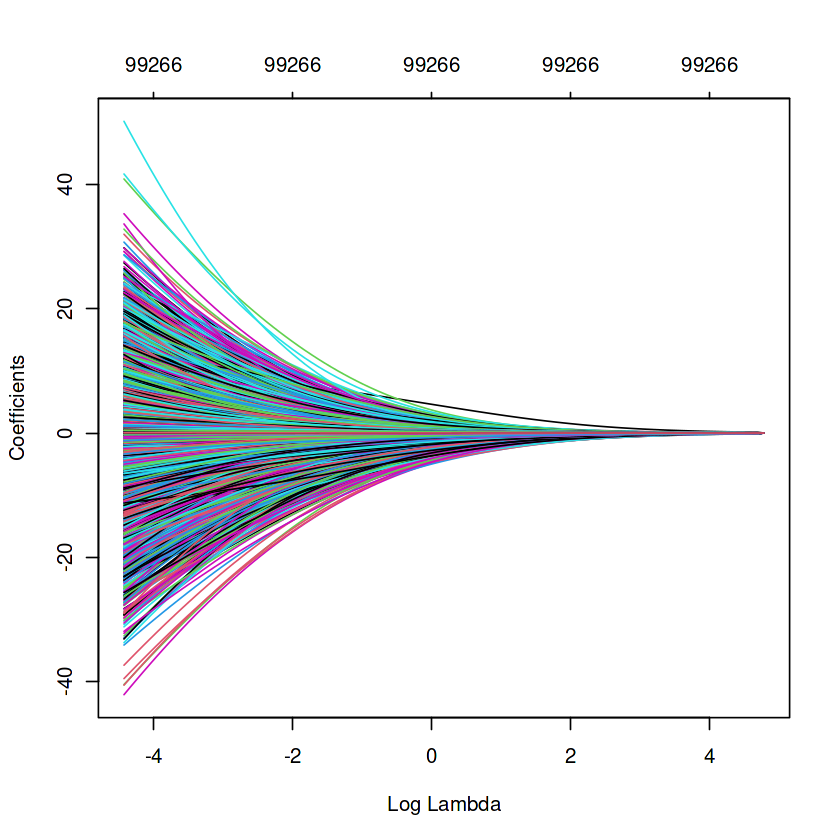

In [21]:
# Ridge Regression

fit_ridge <- glmnet::glmnet(train, target, family = "binomial",
                           standardize = TRUE, alpha = 0) # 0 for ridge

plot(fit_ridge, "lambda")
summary(fit_ridge)

### 4.1.2 Ridge Regression with Cross-Validation

Next, we perform a cross-validated Ridge logistic regression using `cv.glmnet`. We add `AUC`, area under the curve as a performance metric parameter, and we use a 5-fold cross-validation.

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2967912,158.6,43859108,2342.4,55902729,2985.6
Vcells,213366822,1627.9,627732155,4789.3,626740721,4781.7


[1] 0.543237

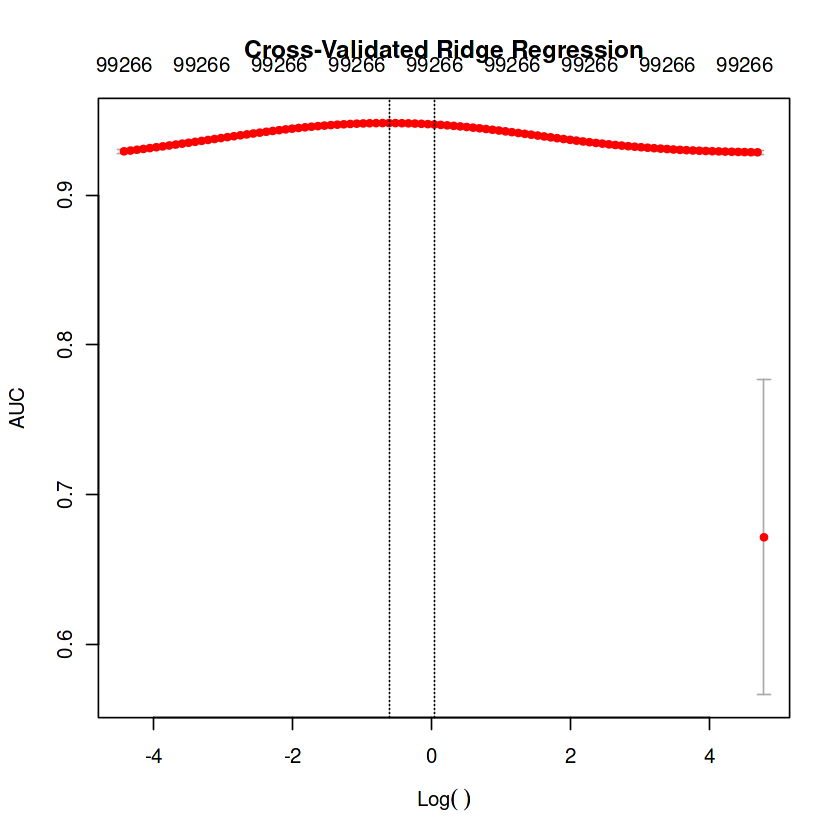

In [22]:
# Ridge Regression with Cross-Validation

gc(verbose = FALSE, full = TRUE) # for memory

fit_ridge_cv <- glmnet::cv.glmnet(train, target, family = "binomial",
                                  standardize = TRUE, parallel = TRUE, 
                                 type.measure = "auc", nfold = 5, alpha = 0)

#fit_ridge_cv
plot(fit_ridge_cv, main = "Cross-Validated Ridge Regression")

fit_ridge_cv$lambda.min # optimal lambda

In [23]:
# Area under the curve (AUC)
ridge_auc <- max(fit_ridge_cv$cvm)
ridge_auc

[1] 0.948164

### 4.1.3 Lasso Regression

Here, we fit a Lasso logistic regression model using the `glmnet` package. We standardize the predictors, set the alpha parameter to 1 for Lasso regularization, and plot the regularization path. Then, we provide a summary of the model, including information about lambda values and coefficients.

           Length  Class     Mode     
a0             100 -none-    numeric  
beta       9926600 dgCMatrix S4       
df             100 -none-    numeric  
dim              2 -none-    numeric  
lambda         100 -none-    numeric  
dev.ratio      100 -none-    numeric  
nulldev          1 -none-    numeric  
npasses          1 -none-    numeric  
jerr             1 -none-    numeric  
offset           1 -none-    logical  
classnames       2 -none-    character
call             6 -none-    call     
nobs             1 -none-    numeric  

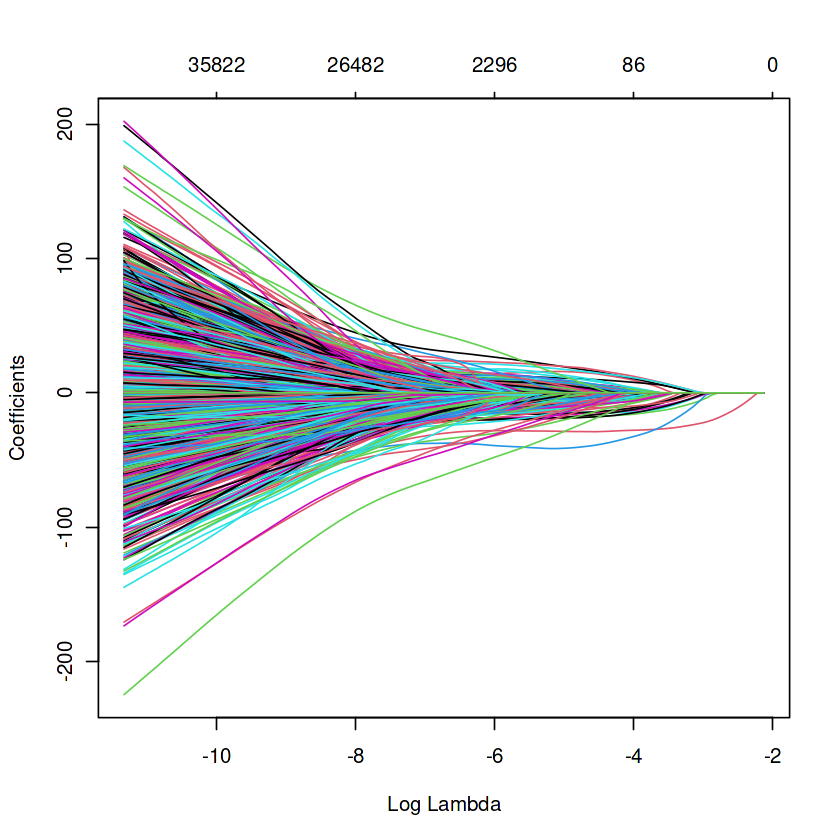

In [24]:
# Lasso Regression

fit_lasso <- glmnet::glmnet(train, target, family = "binomial",   
                            standardize = TRUE, alpha = 1)  # 1 for lasso           

plot(fit_lasso, "lambda")
summary(fit_lasso)

### 4.1.4 Lasso Regression with Cross-Validation

Next, we perform a cross-validated Lasso logistic regression using `cv.glmnet`. We add `AUC` again as a performance metric parameter, and we use a 5-fold cross-validation.

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3000961,160.3,28069830,1499.1,55902729,2985.6
Vcells,230813365,1761.0,627732155,4789.3,627732071,4789.3



Call:  glmnet::cv.glmnet(x = train, y = target, type.measure = "auc",      nfolds = 5, parallel = TRUE, family = "binomial", standardize = TRUE,      alpha = 1) 

Measure: AUC 

      Lambda Index Measure        SE Nonzero
min 0.001255    50  0.9505 0.0006951    7816
1se 0.001512    48  0.9500 0.0006996    5680

[1] 0.001254948

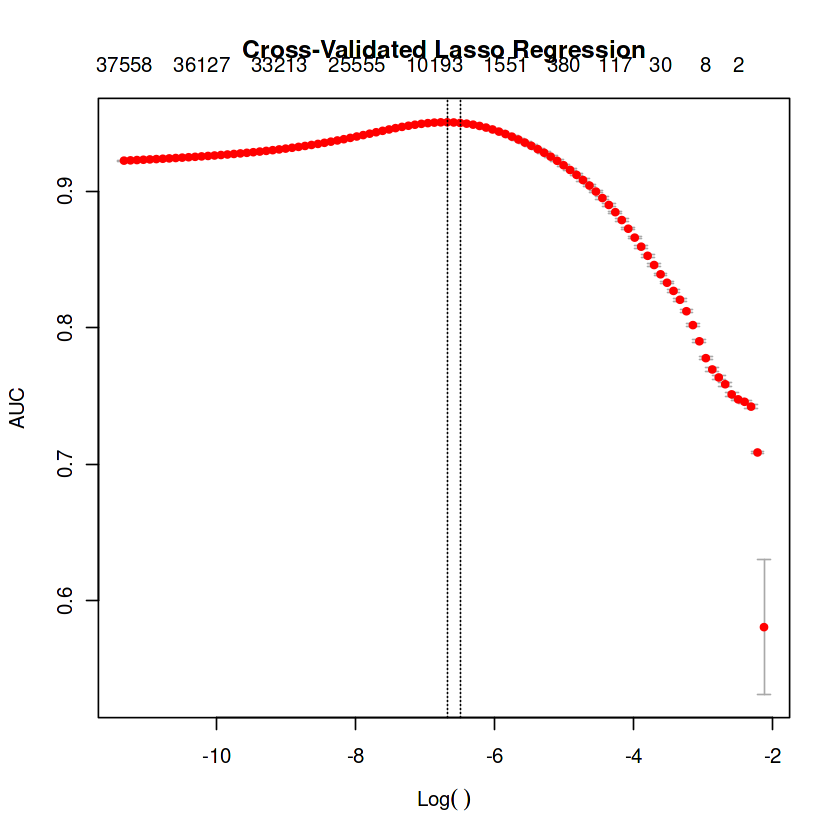

In [25]:
# Lasso Regression with Cross-Validation

gc(verbose = FALSE, full = TRUE) # for memory

fit_lasso_cv <- glmnet::cv.glmnet(train, target, family = "binomial", 
                                  standardize = TRUE, parallel = TRUE, 
                                  type.measure = "auc", nfold = 5, alpha = 1)

fit_lasso_cv
plot(fit_lasso_cv, main = "Cross-Validated Lasso Regression")

fit_lasso_cv$lambda.min # optimal lambda

In [26]:
# Area under the curve (AUC) - without NRC, AFINN and VADER
lasso_auc <- max(fit_lasso_cv$cvm)
lasso_auc

[1] 0.9504781

## 4.2 Model Evaluation <a class="anchor"  id="section4.2"></a>



To evaluate the model you can look at various predictive performance measures. Given that AUC is our primary evaluation metrix in this competition, it is of special importance. But other performance indicators are interesting to look at too. 

Performance metrics:
* `AUC`
* `Accuracy`

In [27]:
## MODEL PERFORMANCE FOR LASSO WITH CROSS VALIDATION

#Predictions - Lasso
lasso_pred_train <- predict(fit_lasso_cv, 
                          train,
                          s = "lambda.min", 
                          type = "class") %>%
                as.factor()

# Confusion Matrix 
lasso_confMatrix <- caret::confusionMatrix(lasso_pred_train, target); lasso_confMatrix

# specifically, accuracy:
lasso_acc <- mean(lasso_pred_train == target)

# Area under the curve (AUC)
lasso_auc <- max(fit_lasso_cv$cvm)

Confusion Matrix and Statistics

              Reference
Prediction     Dissatisfied Satisfied
  Dissatisfied        28370      2929
  Satisfied            7823    114409
                                          
               Accuracy : 0.93            
                 95% CI : (0.9287, 0.9312)
    No Information Rate : 0.7643          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7961          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7839          
            Specificity : 0.9750          
         Pos Pred Value : 0.9064          
         Neg Pred Value : 0.9360          
             Prevalence : 0.2357          
         Detection Rate : 0.1848          
   Detection Prevalence : 0.2039          
      Balanced Accuracy : 0.8794          
                                          
       'Posi

In [28]:
## MODEL PERFORMANCE FOR RIDGE REGRESSION WITH CROSS VALIDATION

# Predictions
ridge_pred_train <- predict(fit_ridge_cv, 
                          train,
                          s = "lambda.min", 
                          type = "class") %>%
                as.factor()

# Confusion Matrix
ridge_confMatrix <- caret::confusionMatrix(ridge_pred_train, target); ridge_confMatrix

# specifically, accuracy:
ridge_acc <- mean(ridge_pred_train == target)

# Area under the curve (AUC)
ridge_auc <- max(fit_ridge_cv$cvm)

Confusion Matrix and Statistics

              Reference
Prediction     Dissatisfied Satisfied
  Dissatisfied        26218       764
  Satisfied            9975    116574
                                          
               Accuracy : 0.9301          
                 95% CI : (0.9288, 0.9313)
    No Information Rate : 0.7643          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7872          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7244          
            Specificity : 0.9935          
         Pos Pred Value : 0.9717          
         Neg Pred Value : 0.9212          
             Prevalence : 0.2357          
         Detection Rate : 0.1708          
   Detection Prevalence : 0.1757          
      Balanced Accuracy : 0.8589          
                                          
       'Posi

In [29]:
# Tabulating the performances

models <- c("Lasso", "Ridge")
acc <- c(lasso_acc, ridge_acc)
auc <- c(lasso_auc, ridge_auc)

# table
comparison_table <- data.frame(models, acc, auc)
comparison_table

models,acc,auc
<chr>,<dbl>,<dbl>
Lasso,0.9299685,0.9504781
Ridge,0.9300532,0.9481640


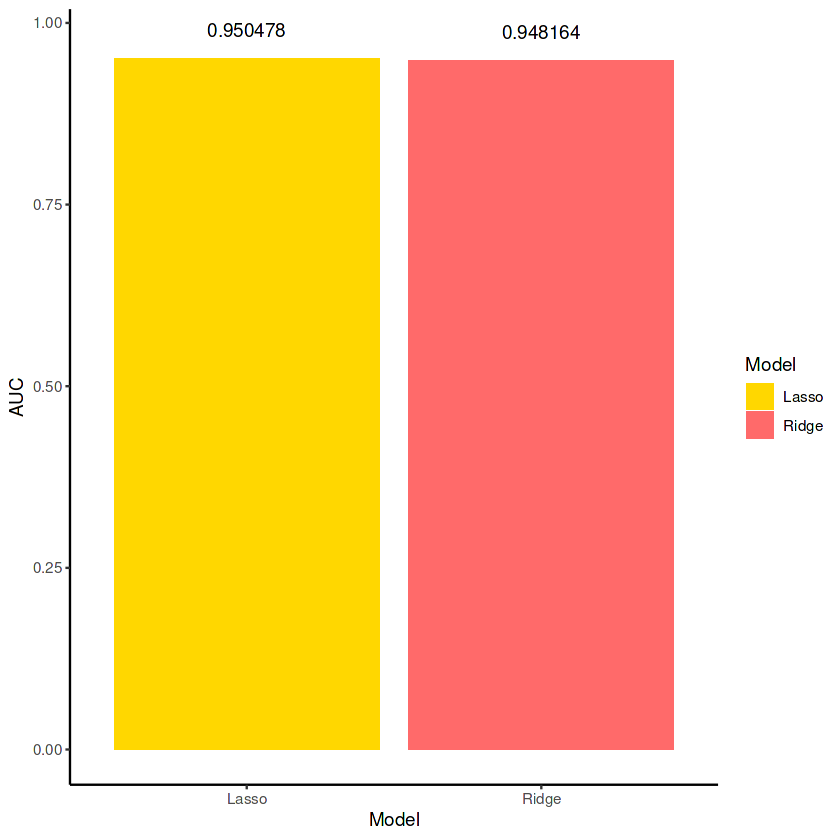

In [30]:
plot_data <- data.frame(Model = c("Ridge", "Lasso"), AUC = c(ridge_auc, lasso_auc))

# Create the bar plot using ggplot
plot <- ggplot(plot_data, aes(x = Model, y = AUC, fill = Model)) +
  geom_bar(stat = "identity") +
  xlab("Model") +
  ylab("AUC") +
  scale_fill_manual(values = c("Ridge" = "indianred1", "Lasso" = "gold1")) +
  geom_text(aes(label = round(AUC, 6), y = AUC + 0.02), vjust = -0.5) +  # Add labels above the bars
  theme_classic()

# Display the plot
print(plot)


## 4.3 Conclusions & Insight into the Models <a class="anchor"  id="section4.3"></a>

In our analysis, we evaluated the performance of different models using key metrics such as `AUC` and `accuracy`. After careful examination, it became evident that the cross-validated Lasso regression model outperformed the alternatives (AUC = 0.9504). This model exhibited better predictive power, making it the preferred choice for our final predictions. 

# 5. Predictions <a class="anchor"  id="section5"></a>

Now we will make predictons on the test set using the cross-validated Lasso model and submit our predictions to the competition. 

In [31]:
# make predictons
pred_lasso_cv <- predict(fit_lasso_cv, 
                          test,
                          s = "lambda.min", 
                          type = "response")

preds_final <- tibble(Id = rownames(pred_lasso_cv), 
                        Prediction = pred_lasso_cv[,1]) %>%
                        arrange(as.integer(Id)) 

# write predictions to csv.
write_csv(preds_final, file="predictions_lassoCV.csv")

# 6. Division of Labor <a class="anchor"  id="section6"></a>

* **Ece:** Code styling, notebook structure & texts, data processing, features engineering, model fitting & predictions
* **Rebeka:** Answer to three questions, data description and goals, features engineering, model fitting & predictions
* **Nitya:** Literature search, feature engineering, model fitting round 2, model performance evaluation, notebook text & structuring


# References

* Bhaskar, J., Sruthi, K., & Nedungadi, P. (2014). Enhanced sentiment analysis of informal textual communication in social media by considering objective words and intensifiers. IEEE International Conference on Recent Advances and Innovations in Engineering (ICRAIE-2014). https://doi.org/10.1109/icraie.2014.6909220

* Cao, Y. (2020). A Corpus-Based Study of Synonymous Intensifiers: Absolutely, Totally, Completely. Proceedings of the 2nd International Conference on Literature, Art and Human Development (ICLAHD 2020). https://doi.org/10.2991/assehr.k.201215.483

* Carrillo-De-Albornoz, J., Vidal, J. R., & Plaza, L. (2018). Feature engineering for sentiment analysis in e-health forums. PLOS ONE, 13(11), e0207996. https://doi.org/10.1371/journal.pone.0207996

* Eslami, S. P., Deal, K. & Hassanein, K. (2018, June 4). "Reviews’ length and sentiment as correlates of online reviews’ ratings." Internet Research, 28(3), 544–563. https://doi.org/10.1108/intr-12-2016-0394

* Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

* Intensifiers ( very, at all ). (2023). In Cambridge Grammar. https://dictionary.cambridge.org/grammar/british-grammar/intensifiers-very-at-all

* Intensifiers. (2010, March 11). LearnEnglish. https://learnenglish.britishcouncil.org/grammar/english-grammar-reference/intensifiers

* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An introduction to statistical learning (1st ed.). Springer.

* Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

* Mohammad, S. M., & Turney, P. D. (2012). CROWDSOURCING A WORD-EMOTION ASSOCIATION LEXICON. Computational Intelligence, 29(3), 436–465. https://doi.org/10.1111/j.1467-8640.2012.00460.x

* Mukherjee, S., & Bala, P. K. (2017). Detecting sarcasm in customer tweets: an NLP based approach. Industrial Management and Data Systems, 117(6), 1109–1126. https://doi.org/10.1108/imds-06-2016-0207

* Nielsen, F. Å. (2011). A new ANEW: Evaluation of a word list for sentiment analysis in microblogs. http://arxiv.org/abs/1103.2903.

* Ohashi, H. (2006). THE DEVELOPMENT OF AN ENGLISH INTENSIFIER PHRASE. English Linguistics, 23(2), 403–432. https://doi.org/10.9793/elsj1984.23.403

* Sarsam, S. M., Al-Samarraie, H., Alzahrani, A. I., & Wright, B. (2020). Sarcasm detection using machine learning algorithms in Twitter: A systematic review. International Journal of Market Research, 62(5), 578–598. https://doi.org/10.1177/1470785320921779

* Su, Y. (2016). Corpus-based comparative study of intensifiers: quite, pretty, rather and fairly. Journal of World Languages, 3(3), 224–236. https://doi.org/10.1080/21698252.2017.1308306
